In [26]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import scipy.stats as st
from tqdm import tqdm
import locale
import matplotlib.pyplot as plt
locale.setlocale(locale.LC_NUMERIC, 'uk_UA')

'uk_UA'

In [27]:
data = pd.read_csv('https://raw.githubusercontent.com/Aranaur/aranaur.rbind.io/main/lectures/asa/labs/2023/data/bootstrap.csv', delimiter=';')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [29]:
data = data[:-5]
data

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
990,991,"10,916229376436",Treatment
991,992,"11,1608693155642",Treatment
992,993,"8,20251753625936",Treatment
993,994,"9,7821993531842",Treatment


In [30]:
control = data[data["experimentVariant"] == "Control"]['value'].apply(locale.atof)
test = data[data["experimentVariant"] == "Treatment"]['value'].apply(locale.atof)
control

0      10.380495
1       9.546867
2      11.088215
3      10.147274
4       9.789808
         ...    
495    10.973929
496    10.261074
497     8.780090
498    11.169078
499    11.499566
Name: value, Length: 500, dtype: float64

In [31]:
test

500    10.380495
501     9.546867
502    11.088215
503    10.147274
504     9.789808
         ...    
990    10.916229
991    11.160869
992     8.202518
993     9.782199
994    10.484967
Name: value, Length: 495, dtype: float64

In [32]:
def get_bootstrap(
    data_column_1, # числові значення першої вибірки
    data_column_2, # числові значення другої вибірки
    boot_it = 1000, # кількість ітерацій бутстрепа
    statistic = np.mean, # яку статистику рахуємо
    bootstrap_conf_level = 0.95 # рівень значущості
):
    boot_len = max([len(data_column_1), len(data_column_2)]) # довжина вибірки
    boot_data = [] # будуватимемо розподіл тут
    for i in tqdm(range(boot_it)): # створюємо підвибірки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр повернення
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # рахуємо статистику
        
    pd_boot_data = pd.DataFrame(boot_data) # перетворюємо в датафрейм
        
    left_quant = (1 - bootstrap_conf_level)/2 # ліва квантиль
    right_quant = 1 - (1 - bootstrap_conf_level) / 2 # права квантиль
    ci = pd_boot_data.quantile([left_quant, right_quant]) # ДІ
    # рахуємо p-value    
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2 # подвоюємо, бо двосторонній критерій
        
    # Візуалізуємо розподіл
    plt.hist(pd_boot_data[0], bins = 50)
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--', color='red')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

100%|██████████| 10000/10000 [00:00<00:00, 13792.59it/s]


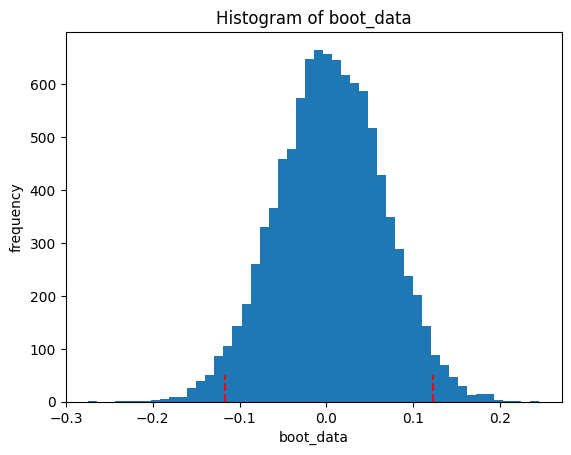

Значення p-value 0.9373433129935569
Довірчий інтервал               0
0.025 -0.116544
0.975  0.123145


In [33]:
booted_data = get_bootstrap(
    data_column_1=pd.Series(control), 
    data_column_2=pd.Series(test), 
    boot_it=10000, 
    statistic=np.average, 
    bootstrap_conf_level=0.95
)

print(f'Значення p-value {booted_data["p_value"]}')
print(f'Довірчий інтервал {booted_data["ci"]}')

In [34]:
stat, p = st.mannwhitneyu(control, test)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=124189.500, p=0.923


100%|██████████| 10000/10000 [00:00<00:00, 10662.94it/s]


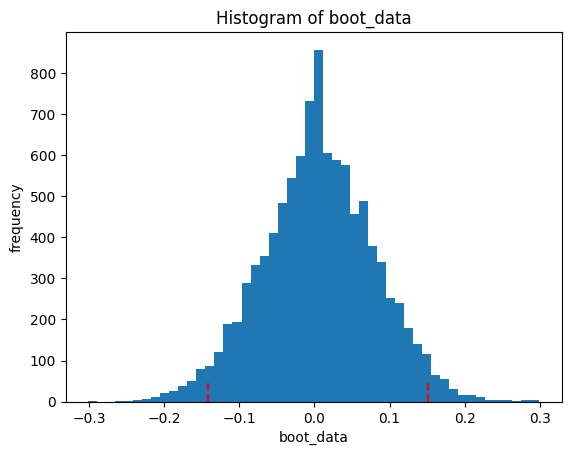

Значення p-value 0.9376640035283517
Довірчий інтервал               0
0.025 -0.141278
0.975  0.150902


In [35]:
booted_data = get_bootstrap(
    data_column_1=pd.Series(control), 
    data_column_2=pd.Series(test), 
    boot_it=10000, 
    statistic=np.median, 
    bootstrap_conf_level=0.95
)

print(f'Значення p-value {booted_data["p_value"]}')
print(f'Довірчий інтервал {booted_data["ci"]}')

In [36]:
stat, p = st.mannwhitneyu(control, test)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=124189.500, p=0.923
